# Delivery Date Prediction

## EDA

In [11]:
# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

In [202]:
## Import all modues
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pkg.data import get_data
import datetime

### Prepare dataset

In [312]:
## load tables
orders = get_data()['orders'].copy()

items = get_data()['order_items'].copy()

customers = get_data()['customers'].copy()

sellers = get_data()['sellers'].copy()

geo = get_data()['geolocation'].copy()

* Listed Necessary Column/Features:
     - Delivery Date (orders)
     - Estimated delivery date (orders)
     - Purchase Date (orders)
     - Time on the way (derived)
     - Time before carrier (derived)
     - Distance of Delivery (derived)

#### Get Delivery Distance


* In order to compute distance between the customer and the seller, we need their zip code (associated latitude & longitude)

In [313]:
### Get the seller zip code of each order
middle = items[['order_id', 'seller_id']]
middle_2 = middle.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on = "seller_id", how = "outer")
orders = orders.merge(middle_2, on = "order_id", how = "left")

### Get customer zip code of each order
orders = orders.merge(customers[['customer_id', 'customer_zip_code_prefix']],
             on = 'customer_id', how = "left")


## Clean geo df
geo = geo[~geo['geolocation_zip_code_prefix'].duplicated()]

## add seller coordinates to the orders
orders = orders.merge(geo, 
             left_on = "seller_zip_code_prefix", 
             right_on = "geolocation_zip_code_prefix", 
             how = "left")

## add customer coordinates to the orders
orders = orders.merge(geo, 
             left_on = "customer_zip_code_prefix", 
             right_on = "geolocation_zip_code_prefix", 
             how = "left",
             suffixes = ("_seller", "_customer"))

In [314]:
## Clean orders
## 1--Filter out orders with multipul sellers
# Because each order only has one delivery date

df = orders.groupby(by="order_id").nunique()

mono_orders = pd.Series(df[df['seller_id'] == 1].index)

filtered_orders = orders.merge(mono_orders, how = 'inner')


## 2--drop rows with missing values
#filtered_orders.isna().sum()
filtered_orders = filtered_orders.drop(columns = ["order_approved_at"])

filtered_orders = filtered_orders.dropna()

In [184]:
## define a function to get distance from coordinates
from math import radians, sin, cos, asin, sqrt
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of (lat, lng)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

## add distance column to dateset
filtered_orders['distance'] = filtered_orders.apply(
    lambda row: haversine_distance(
        row["geolocation_lng_seller"],
        row["geolocation_lat_seller"],
        row["geolocation_lng_customer"],
        row["geolocation_lat_customer"],
    ),
    axis=1,
)

#### Drop/Convert some columns 

In [191]:
## only choose columns needed for the model
data = filtered_orders[['order_id', 
                 'distance',
                 'order_purchase_timestamp',
       'order_delivered_carrier_date', 'order_delivered_customer_date', 
     'order_estimated_delivery_date']]

In [197]:
## Convert time columns
time_columns = ['order_purchase_timestamp',
                 'order_delivered_carrier_date', 
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']

for column in time_columns:
    data.loc[:, column] = pd.to_datetime(data[column])

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [201]:
data.head()

,order_id,distance,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,18.063837,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,856.292580,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,514.130333,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,1822.800366,2017-11-18 19:28:06,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,30.174037,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


#### Get Time before carrier

In [207]:
## Compute the number of days
one_day_delta = datetime.timedelta(days = 1) # get a "timedelta" object

data.loc[:, "days_before_carrier"] = \
round((data['order_delivered_carrier_date'] - data['order_purchase_timestamp']) / one_day_delta, 2)

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Get Time on the way/Wait time

In [210]:
data.loc[:, "days_on_way"] = \
round((data['order_delivered_customer_date'] - data['order_delivered_carrier_date']) / one_day_delta, 2)

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [236]:
data.loc[:, "wait_time"] = \
round((data['order_delivered_customer_date'] - data['order_purchase_timestamp']) / one_day_delta, 2)

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Handle Unvalid Data

In [225]:
# Assign 0 to days_before_carrier below 0
data.loc[data['days_before_carrier'] < 0, 'days_before_carrier'] = 0


/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [241]:
# Assign wait time to days_on_way below 0

data.loc[data['days_on_way'] < 0, 'days_on_way'] = \
data[data['days_on_way'] < 0]['wait_time']

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Explore the data

#### Distribution of the target


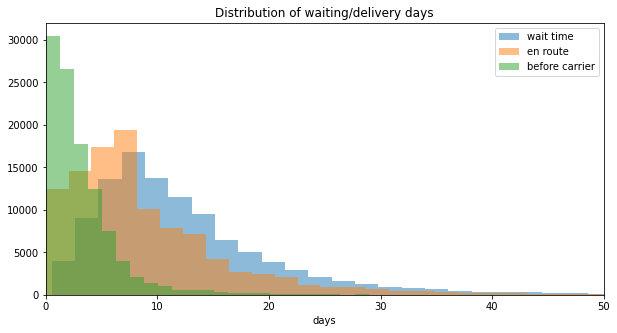

In [259]:
### Distribution of wait-time

plt.figure(figsize = (10, 5))

kwargs = dict(histtype = 'stepfilled', alpha = 0.5, bins = 100)

plt.hist(data['wait_time'], label='wait time', **kwargs)
plt.hist(data['days_on_way'], label = "en route", **kwargs)
plt.hist(data['days_before_carrier'], label = "before carrier", **kwargs)

plt.title("Distribution of waiting/delivery days")
plt.xlabel("days")
plt.xlim((0, 50))
plt.legend()

plt.show()

#### Ploting Correlation between distance and delivery time

<Figure size 504x504 with 0 Axes>

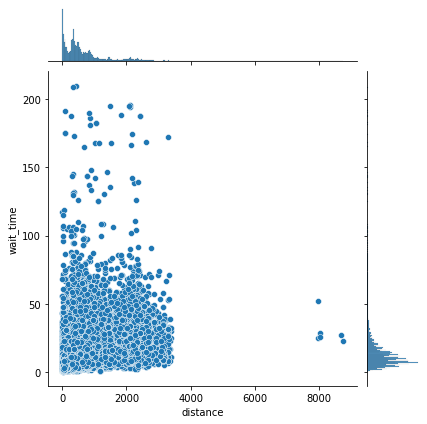

In [293]:
### check correlation
fig = plt.figure(figsize = (7, 7))
sns.jointplot(data = data, x = "distance", y = "wait_time")


<AxesSubplot:>

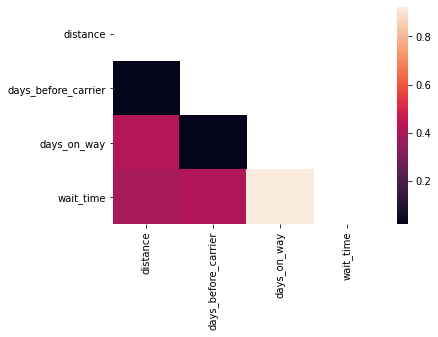

In [294]:
## Heat map
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(),  mask=mask)

> Conclution:
    > * Delivery Time has no coorelation with distance

#### Geospatial Data

In [297]:
# make sur your install folium first
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [298]:
center_location = [-22.9020, -43.1882]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [306]:
%matplotlib notebook
filtered_orders["count"] =1
heatmap_data = filtered_orders.head(10000)[['geolocation_lat_seller', 'geolocation_lng_seller', 'count']].groupby(['geolocation_lat_seller', 'geolocation_lng_seller']).sum().reset_index().values.tolist()
gradient = {0.1: 'blue', 0.2: 'lime', 0.3: 'orange', 0.4: 'red', 0.5: 'purple', 0.6: 'black'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [319]:
data.head()

,order_id,distance,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days_before_carrier,days_on_way,wait_time
0,e481f51cbdc54678b7cc49136f2d6af7,18.063837,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.37,6.06,8.44
1,53cdb2fc8bc7dce0b6741e2150273451,856.292580,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.74,12.04,13.78
2,47770eb9100c2d0c44946d9cf07ec65d,514.130333,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.22,9.18,9.39
3,949d5b44dbf5de918fe9c16f97b45f8a,1822.800366,2017-11-18 19:28:06,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,3.76,9.45,13.21
4,ad21c59c0840e6cb83a9ceb5573f8159,30.174037,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0.94,1.94,2.87


In [326]:
data.head()

,order_id,distance,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days_before_carrier,days_on_way,wait_time
0,e481f51cbdc54678b7cc49136f2d6af7,18.063837,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.37,6.06,8.44
1,53cdb2fc8bc7dce0b6741e2150273451,856.292580,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.74,12.04,13.78
2,47770eb9100c2d0c44946d9cf07ec65d,514.130333,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.22,9.18,9.39
3,949d5b44dbf5de918fe9c16f97b45f8a,1822.800366,2017-11-18 19:28:06,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,3.76,9.45,13.21
4,ad21c59c0840e6cb83a9ceb5573f8159,30.174037,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0.94,1.94,2.87


In [328]:
data = data.merge(filtered_orders[['order_id', 
                            'geolocation_state_seller', 
                            'geolocation_state_customer']],
           on = "order_id",
           how = "left")

In [333]:
data['same_state'] = (data['geolocation_state_customer'] == data['geolocation_state_seller']).astype('float')

In [344]:
state_group = data.groupby('geolocation_state_customer')  #.indices.keys()

In [402]:
top_city = state_group.count()['order_id'].sort_values(ascending = False)[:5].index

<IPython.core.display.Javascript object>


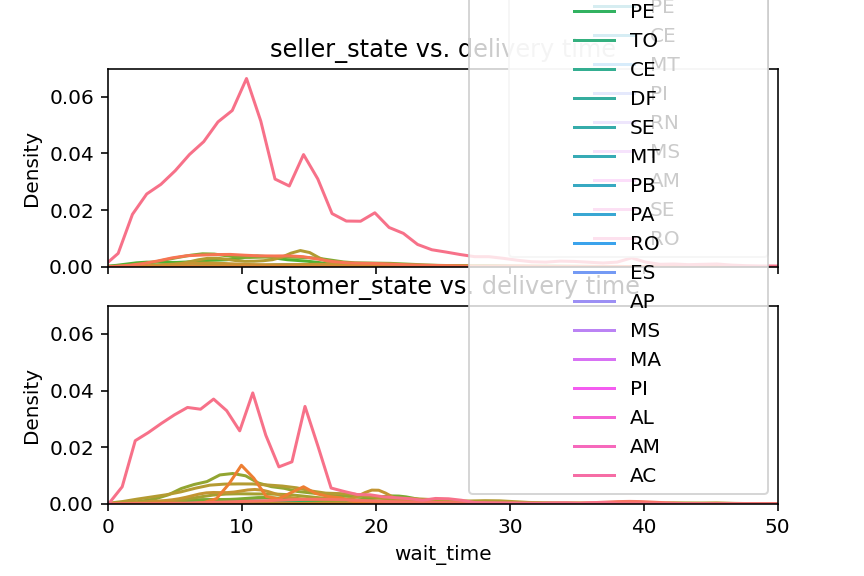

(0.0, 50.0)

In [429]:
fig, ax = plt.subplots(2, sharex = True, sharey = True)
fig.figsize = (0, 7)

ax[0].set_title("seller_state vs. delivery time")
sns.kdeplot(data = data, x = 'wait_time', hue = "geolocation_state_seller", ax = ax[0])

ax[1].set_title("customer_state vs. delivery time")
sns.kdeplot(data = data, x = 'wait_time', hue = "geolocation_state_customer", ax = ax[1])

plt.xlim((0,50))

In [405]:
for city in top_city:
    sdata.loc[data['geolocation_state_seller']==city, 'wait_time']

Series([], Name: wait_time, dtype: float64)

In [396]:
state_group.std()['wait_time']

geolocation_state_customer
AC     6.887265
AL    12.340005
AM     9.849070
AP    29.000448
BA    12.558597
CE    11.665653
DF     9.070442
ES     9.327975
GO     5.756562
MA     9.632759
MG     6.186561
MS     5.853817
MT     7.238774
PA    13.086696
PB     9.293169
PE     9.096364
PI    11.606086
PR     7.192043
RJ    10.177912
RN    11.516820
RO    11.230084
RR    22.051284
RS     8.975532
SC     8.822786
SE    13.234876
SP     5.977959
TO     6.519979
Name: wait_time, dtype: float64

In [394]:
state_group.mean()['wait_time']

geolocation_state_customer
AC    17.219417
AL    26.043234
AM    26.848449
AP    24.928022
BA    21.577725
CE    19.504079
DF    13.147163
ES    15.316716
GO    12.503038
MA    22.971637
MG    11.847903
MS    15.328996
MT    18.999709
PA    24.607766
PB    21.075212
PE    17.691475
PI    18.474002
PR    13.637272
RJ    14.691401
RN    19.327289
RO    24.202749
RR    24.486447
RS    14.441355
SC    16.643946
SE    21.324107
SP     9.534865
TO    15.937851
Name: wait_time, dtype: float64

## Feature Engineering and Selection

## Model Selection